In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from modules import *

In [5]:
data = pd.read_csv("배상면주가_빙탄복.csv", encoding='utf-8-sig')
# data.drop_duplicates(['text'],ignore_index=True, inplace=True) # 중복 제거
data.columns = ['date', 'star','doc']

In [6]:
data

,date,star,doc
0,2022-11-25,5,맛있어요 전에도 사서 마셨는데 맛있습니다
1,2022-11-24,5,항상 복분자주는 여기서 사먹네요 안 독하고 깔끔합니다
2,2022-11-12,5,저번에 대형마트에서 발견해서 먹어봤다 맛있어서 온라인 구매했어요 주변에서 많이 팔면...
3,2022-11-24,5,지인한테 선물받아 먹어보니 너무 맛있어요먹어본 복분자술 중에 단연 최고에요너무 과...
4,2022-11-25,5,잘받았어요잘쓸게유
...,...,...,...
7748,2017-08-14,5,만족스럽습니다
7749,2017-07-26,5,빠른배송 맘에 들고요 가족들과 즐기기 좋습니다 시중에서 구하기 힘들었는데 좋네요
7750,2017-08-16,5,맛있네요
7751,2017-08-08,5,기대이상이에요ㅎ


In [4]:
data.doc = data.doc.str.replace("[^가-힣 ]"," ") # 한글만 남기고 특수문자, 숫자, 영어 삭제
data.doc = data.doc.str.replace("\s+", " ") # white space 삭제
data.doc = data.doc.str.replace("럽고목","럽고 목")

data.doc

0       머루주는 처음 먹어봤는데 아주 맛있네요 적당히 달고 약간 그 포도씨 씹어 먹으면 약...
1       술집에서 한번먹고 여러번 구매해서 먹어요 회사사람들한테까지 퍼뜨려서 먹고있어요 달달...
2                                             먹기전입니다기대됩니다
3                    새콤달콤 넘 맛있어요 고기집에서 처음 먹어보고 맛있어서 주문했어요
4                      막걸리 유통기한도 길고 포장도 엄청 꼼꼼히 해주셨어요 맛있어요
                              ...                        
1047                                                     
1048                                          달달보다는 새콤합네다
1049                                        좋은날에 먹기 좋습니다 
1050                                        부드럽고 향긋해요 맛나요
1051                             포장도 꼼꼼하게 잘 왔습니다 술 맛도 좋아요
Name: doc, Length: 1052, dtype: object

In [5]:
# 검토 후 추가 삭제 문구 적용
data.dropna(inplace=True)

In [6]:
data[data.doc.isnull()]

,date,star,doc


In [7]:
data = data[data.doc.str.contains('맛|향|달|넘김|부드|단|도수|냄세')]
data.reset_index(drop=True, inplace=True)

In [8]:
len(data)

600

In [9]:
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize
from konlpy.tag import Okt

In [10]:
from nltk.util import everygrams

#원하는 태그 추출 & 불용어 제거
okt = Okt()

#불용어
stopwords = pd.read_csv('ko-stopwords.csv') #한국어불용어사전 불러오기
stopwords=list(stopwords['stopwords']) 
stopwords.extend(['에서','고','이다','는','한','씨', "것","거","게","데","이다","건","고","되다","되어다","걸","기",
                  "시","네","듯","랍니","중이","얘","스","도도", "나","수","개","내","기","제","저","인","있다","이렇다",
                  "그렇다","번","위","팅","분","인","링","란","포","두", "진짜", "하다" ,"이다" ,"가다", "이제" ,"들다",
                 '에서','고','이다','쓰리다 도어즈','일요일','휴무','수표','층','틀다','차차','드므','맛집','술집','길',
                 '층','개다 성','사진','파다','동영상','아스 론','자다','는','희다 스토리','한','씨', "것","거","게","데",
                 "이다","건","고","되다","되어다","걸","기", "시","네","듯","랍니","중이","얘","스","도도", "나","수","개",
                 "내","기","제","저","인","있다","이렇다", "그렇다","번","위","팅","분","인","링","란","포","두", "진짜",
                 "하다" ,"이다" ,"가다", "이제" ,"들다", "먹다", "보다"]) #불용어 추가
stopwords.extend(['나다', '안나', '이나', '기대하다', '나서다', '끝','싹','이나고','잇다','기대다','생각','기대',
                  '랄','날','끄다','편이','끼','감','감다','배송','꼼꼼하다','주문'])

stopwords=set(stopwords) # 중복제거    

# 형태소 분석 함수 만들기
def okt_pos_tagging2(string):
    pos_words = okt.pos(string, stem=True, norm=True) # 형태소 분석. 단어는 사전형으로 바꿔주기
    words = [word for word, tag in pos_words if tag 
             in ['Noun', 'Adjective', 'Verb','Adverb'] if word not in stopwords ]

    egram = list(everygrams(words, min_len=1, max_len=1))
    egram_token = [' '.join(grams) for grams in egram]

    return egram_token

def okt_pos_tagging(string):
    pos_words = okt.pos(string, stem=True, norm=True) # 형태소 분석. 단어는 사전형으로 바꿔주기
    words = [word for word, tag in pos_words if tag 
             in ['Noun', 'Adjective', 'Verb','Adverb'] if word not in stopwords ]

    egram = list(everygrams(words, min_len=1, max_len=1))
    egram_token = [' '.join(grams) for grams in egram]

    return egram_token



In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(tokenizer = lambda x: okt_pos_tagging(x))
bow_vect = vect.fit_transform(data['doc'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)


In [12]:
bow_vect.shape

(600, 1002)

In [13]:
word_count_dict = dict(zip(word_list, count_list))
word_count_dict


{'가게': 1,
 '가격': 13,
 '가까이': 1,
 '가깝다': 1,
 '가능하다': 1,
 '가득': 4,
 '가득하다': 3,
 '가려지다': 1,
 '가볍다': 5,
 '가성': 1,
 '가시다': 1,
 '가장': 1,
 '가져가다': 1,
 '가족': 7,
 '가지': 1,
 '간단하다': 2,
 '간편하다': 1,
 '갈다': 3,
 '갈리다': 1,
 '갈릴': 2,
 '감돌다': 1,
 '감동': 1,
 '감미롭다': 1,
 '감사': 3,
 '감사하다': 9,
 '갓': 1,
 '강': 1,
 '강추': 4,
 '강츄용': 1,
 '강하': 1,
 '강하다': 20,
 '갖다': 1,
 '개강': 1,
 '개다': 1,
 '개인': 8,
 '개취': 1,
 '갠': 1,
 '갯수': 1,
 '거리': 1,
 '거마': 1,
 '걱정': 4,
 '건강하다': 1,
 '걸다': 1,
 '검': 1,
 '겁니다': 2,
 '겠다': 2,
 '견디다': 1,
 '겹치': 1,
 '경치': 1,
 '경험': 1,
 '곁들이다': 3,
 '계속': 6,
 '계시다': 1,
 '고급': 2,
 '고급스럽다': 3,
 '고기': 1,
 '고기랑': 3,
 '고맙다': 1,
 '고민': 3,
 '고소하다': 1,
 '고이': 1,
 '고정': 1,
 '고함': 1,
 '고해': 1,
 '곳': 2,
 '과실': 1,
 '과실주': 5,
 '과일': 6,
 '과즙': 1,
 '괜': 1,
 '괜찮다': 12,
 '괴롭다': 1,
 '굉장하다': 3,
 '구경': 1,
 '구내': 1,
 '구리': 3,
 '구리구리': 1,
 '구매': 36,
 '구수하다': 2,
 '구입': 6,
 '구천동': 2,
 '국산': 1,
 '굳다': 9,
 '굳이': 1,
 '굿': 7,
 '굿굿': 1,
 '궁금하다': 3,
 '귀엽다': 1,
 '귣귣': 1,
 '그게': 1,
 '그냥': 8,
 '그대로': 2,
 '그동안': 1,
 '그만': 2,
 '그야말로': 1

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [15]:
print(tf_idf_vect[0])

  (0, 935)	0.2005362110302499
  (0, 932)	0.26137097336031284
  (0, 857)	0.18063988911455667
  (0, 800)	0.18940659000823534
  (0, 757)	0.18479210864447326
  (0, 657)	0.15714151699062023
  (0, 571)	0.1717792185988883
  (0, 560)	0.27819273556618146
  (0, 505)	0.12412565311875318
  (0, 400)	0.20746687912357734
  (0, 313)	0.2206787507034583
  (0, 312)	0.11802043999363157
  (0, 303)	0.06949208830241335
  (0, 296)	0.08672259835028334
  (0, 188)	0.16188812448634715
  (0, 162)	0.3435584371977766
  (0, 159)	0.22621864375178682
  (0, 156)	0.26137097336031284
  (0, 123)	0.22621864375178682
  (0, 89)	0.27819273556618146
  (0, 59)	0.27819273556618146
  (0, 8)	0.23261398092895127


In [16]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')

{312: '머루', 800: '주다', 857: '처음', 571: '아주', 303: '맛있다', 757: '적당하다', 188: '달', 935: '포도', 560: '씹다'...


In [17]:
def rating_to_label(rating):
    if rating > 3:
        return 1
    else:
        return 0

data['y'] = data['star'].apply(lambda x : rating_to_label(x))
len(data[data['y']==0])

36

In [18]:
from sklearn.model_selection import train_test_split

x = tf_idf_vect
y = data['y']

# positive_random_idx = data[data['y']==1].sample(48, random_state=12).index.tolist()
# negative_random_idx = data[data['y']==0].sample(48, random_state=12).index.tolist()

# random_idx = positive_random_idx + negative_random_idx
# x = tf_idf_vect[random_idx]
# y = data['y'][random_idx]


# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)


In [19]:
x.shape,y.shape

((600, 1002), (600,))

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fit in training set
lr = LogisticRegression()
lr.fit(x, y)

# predict in test set
y_pred = lr.predict(x)

In [21]:
print('accuracy: %.4f' % accuracy_score(y, y_pred))
print('precision: %.4f' % precision_score(y, y_pred))
print('recall: %.4f' % recall_score(y, y_pred))
print('F1: %.4f' % f1_score(y, y_pred))


accuracy: 0.9400
precision: 0.9400
recall: 1.0000
F1: 0.9691


In [22]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
coef_pos_index



[(1.8920312786783515, 303),
 (1.1279988079813377, 793),
 (0.7443779616852932, 190),
 (0.5510705137998475, 418),
 (0.46010586700037076, 505),
 (0.4423713052716286, 312),
 (0.4127559439607318, 77),
 (0.3912528147575361, 276),
 (0.37281409434178836, 149),
 (0.36457169635655085, 328),
 (0.34954870953483486, 757),
 (0.3299003067304807, 214),
 (0.3277561814600948, 891),
 (0.30943784190703366, 938),
 (0.3093125322796667, 150),
 (0.29315809620867217, 444),
 (0.27663952683278975, 745),
 (0.267989741644469, 572),
 (0.25831045131083324, 405),
 (0.24510786684059974, 966),
 (0.23939703247099436, 657),
 (0.23843644622299956, 70),
 (0.23338087178749556, 400),
 (0.22682806434390562, 293),
 (0.21982486921266295, 474),
 (0.21764167357262137, 825),
 (0.2164081310122303, 892),
 (0.2155060280114696, 935),
 (0.2095956018550079, 476),
 (0.20902452874820457, 706),
 (0.19707859530072558, 663),
 (0.19153800691595935, 307),
 (0.19019758563587547, 296),
 (0.18990103220306442, 744),
 (0.18878247409872517, 659),
 (

In [23]:
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])


맛있다 1.8920312786783515
좋다 1.1279988079813377
달달 0.7443779616852932
빠르다 0.5510705137998475
술 0.46010586700037076
머루 0.4423713052716286
구매 0.4127559439607318
마시다 0.3912528147575361
넘김 0.37281409434178836
목 0.36457169635655085
적당하다 0.34954870953483486
더 0.3299003067304807
콤 0.3277561814600948
포장 0.30943784190703366
넘다 0.3093125322796667
산 0.29315809620867217
재다 0.27663952683278975
아직 0.267989741644469
부드럽다 0.25831045131083324
해주다 0.24510786684059974


In [24]:
for coef in coef_neg_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])


아니다 -1.2323987282246713
강하다 -1.1154716351543097
입맛 -1.0816651305042884
엄청 -1.045585266645928
느낌 -1.015515029876968
알콜 -1.011597953917418
별로 -0.9568701941131167
셔 -0.8399047194704332
덜 -0.7321496807041281
숙성 -0.706664156463877
자체 -0.662085576461167
임 -0.6333285320190515
텁텁했네 -0.6314549512588176
단맛 -0.6310564204517594
완벽하다 -0.6021969590797547
신 -0.5750340596364274
달 -0.5608431060433866
발 -0.5339729355548981
희다 -0.5279971820540875
가득 -0.5148440068131817


In [25]:
for coef in coef_neg_index[:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

아니다 -1.2323987282246713
강하다 -1.1154716351543097
입맛 -1.0816651305042884
엄청 -1.045585266645928
느낌 -1.015515029876968
알콜 -1.011597953917418
별로 -0.9568701941131167
셔 -0.8399047194704332
덜 -0.7321496807041281
숙성 -0.706664156463877
자체 -0.662085576461167
임 -0.6333285320190515
텁텁했네 -0.6314549512588176
단맛 -0.6310564204517594
완벽하다 -0.6021969590797547
신 -0.5750340596364274
달 -0.5608431060433866
발 -0.5339729355548981
희다 -0.5279971820540875
가득 -0.5148440068131817
매다 -0.5032700117714017
전통주 -0.5019175649599881
맞다 -0.4991950885721087
작다 -0.4794179688947758
덜하다 -0.478924872680058
과실 -0.47333805929532136
깔끔하다 -0.46753969509921495
놀래다 -0.4613632349437292
입 -0.45684524127666054
다르다 -0.4567156298004541
사다 -0.4534573950340195
음 -0.45219346917394154
떫 -0.45040343383237225
단 -0.443214554774052
실망 -0.443214554774052
주스 -0.433914097712133
의외로 -0.432798889464126
텁텁 -0.432798889464126
시어 -0.42681428152232803
요리 -0.4213325190880519
갠 -0.4109548493349286
별루 -0.4109548493349286
컷 -0.4109548493349286
전혀 -0.408977746

In [26]:
tokens = [] 
# tokens.append()
for i in data['doc']:
    token = okt_pos_tagging2(i)
    tokens.append(token)

In [27]:
tokens

[['머루',
  '주다',
  '처음',
  '아주',
  '맛있다',
  '적당하다',
  '달',
  '포도',
  '씹다',
  '고소하다',
  '맛',
  '그게',
  '끝맛',
  '느껴지다',
  '와인',
  '느낌',
  '술',
  '복분자',
  '농도',
  '가볍다',
  '느낌',
  '먹기',
  '편하다'],
 ['한번', '구매', '회사', '사람', '퍼뜨려', '달달', '도수', '알콜', '부족하다', '않다', '아주', '좋다'],
 ['콤달콤', '넘다', '맛있다', '집', '처음', '보고', '맛있다'],
 ['막걸리', '유통', '기한', '길다', '포장', '엄청', '해주다', '맛있다'],
 ['빠르다', '포장', '상태', '마음', '술', '맛있다', '자주', '애용', '수고'],
 ['처음', '땐', '단가', '너무', '맛있다'],
 ['포장', '던지다', '깨다', '처럼', '왓구', '따다', '넘다', '맛있다', '인터넷', '켯'],
 ['머루', '함량', '높다', '향', '긋다', '맛', '좋다'],
 ['맛있다', '다'],
 ['머루', '주', '맛있다'],
 ['맛있다', '맛있다', '맛있다'],
 ['가격', '착하다', '빨르다', '알콜', '도수', '몸', '따뜻하다'],
 ['포장', '너무', '보내다', '산', '머루', '주', '너무', '맛있다', '재다', '의사'],
 ['지인', '집', '보고', '너무', '맛있다', '구입', '달콤하다', '맛', '도수'],
 ['엄청', '맛있다', '술', '호'],
 ['엄청', '달다', '술', '마시다', '사람', '기분', '좋다', '말다', '술'],
 ['머루', '맛', '세다', '좋다'],
 ['술', '자체', '맛', '좋다', '달달', '와인', '느낌', '드네'],
 ['좋다', '달달', '구리', '최고'],
 ['달달',
  '포도',
 

In [28]:
# tokens2 = []

# for i in tokens:
    
#     tag2=[]
    
#     for j in i:
#         tag1 = okt_pos_tagging(j)
#         tag2 = tag2 + tag1
    
#     tokens2.append(tag2)
    

In [46]:
from gensim.models import Word2Vec

w2v = Word2Vec(tokens, vector_size= 300, window=2, min_count=5, epochs=50)
word_vectors = w2v.wv
vocabs = word_vectors.key_to_index
word_vectors_list = [word_vectors[v] for v in vocabs]
len(vocabs)

167

In [47]:
w2v.wv.most_similar(['맛','마시기','마시다'])

[('말다', 0.9993890523910522),
 ('버리다', 0.9993280172348022),
 ('함', 0.9993207454681396),
 ('차다', 0.9993013739585876),
 ('올라오다', 0.9992755651473999),
 ('더', 0.999259352684021),
 ('냄새', 0.9992552995681763),
 ('기분', 0.9992244243621826),
 ('사람', 0.9991962313652039),
 ('없이', 0.9991884827613831)]

In [48]:
w2v.wv.most_similar(positive=['끝맛'])

[('함', 0.9990919232368469),
 ('쎄다', 0.9990010261535645),
 ('진하다', 0.9989644289016724),
 ('발효', 0.9989112019538879),
 ('올라오다', 0.9988549947738647),
 ('냄새', 0.9988399147987366),
 ('기분', 0.9988391399383545),
 ('시큼하다', 0.9988025426864624),
 ('더', 0.9987717866897583),
 ('복분자', 0.998760998249054)]

In [49]:
w2v.wv.most_similar(positive=['목','넘김'])

[('부드럽다', 0.996715784072876),
 ('않다', 0.9950740933418274),
 ('좋다', 0.9946646094322205),
 ('다양하다', 0.9935300350189209),
 ('아주', 0.9935064315795898),
 ('알콜', 0.993493914604187),
 ('향', 0.9934844374656677),
 ('달다', 0.9934436678886414),
 ('깔끔하다', 0.9934419393539429),
 ('달달', 0.99339759349823)]

In [50]:
w2v.wv.most_similar(positive=['느껴지다','느낌'])

[('복분자', 0.9992130398750305),
 ('홍초', 0.9991747736930847),
 ('시큼하다', 0.9991550445556641),
 ('복분자주', 0.9991500377655029),
 ('느끼다', 0.9991217851638794),
 ('취향', 0.9991068840026855),
 ('담그다', 0.9991008043289185),
 ('더', 0.9990836381912231),
 ('액', 0.9990634322166443),
 ('말다', 0.9990541934967041)]

In [51]:
w2v.wv.most_similar(positive=['향',])

[('아주', 0.998138427734375),
 ('쓰다', 0.9980114102363586),
 ('넘어가다', 0.997959315776825),
 ('특유', 0.9978833198547363),
 ('알', 0.9978408217430115),
 ('진하다', 0.9978150725364685),
 ('맛', 0.997786819934845),
 ('알콜', 0.9976916313171387),
 ('알코올', 0.997678279876709),
 ('강하다', 0.9976611137390137)]

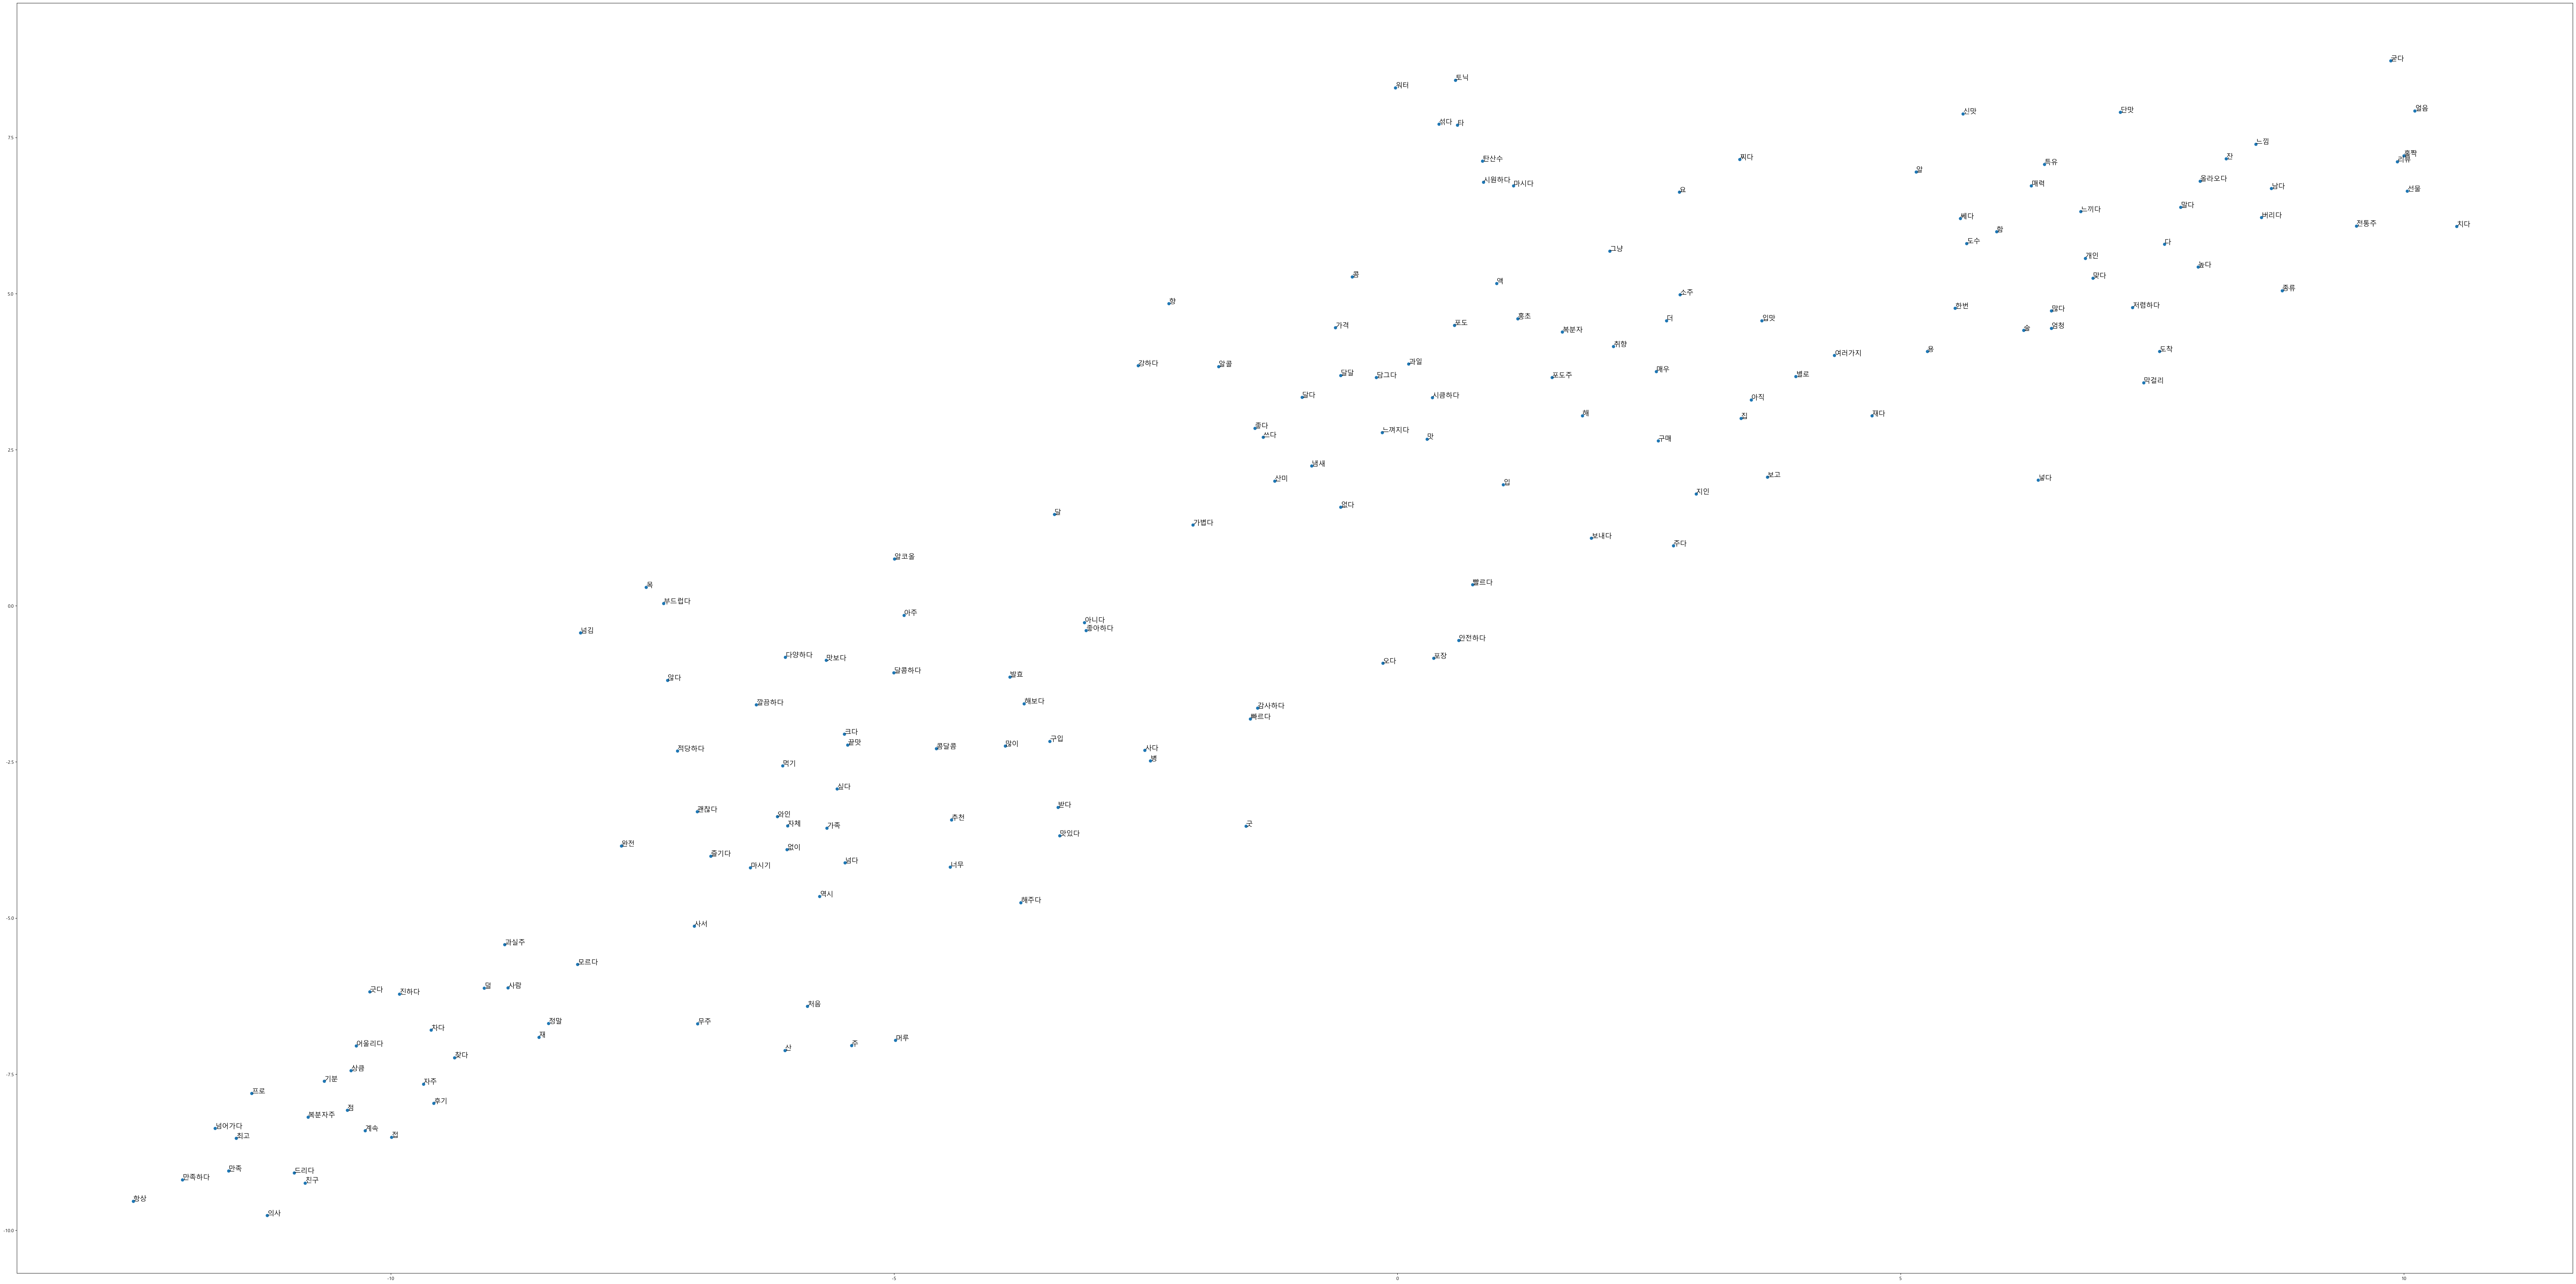

In [52]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g
from matplotlib import font_manager, rc
from sklearn.cluster import DBSCAN

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()

rc('font',family=font_name) # 한글 폰트

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

vocab = list(vocabs)
X = w2v.wv[vocab]

tsne = TSNE(n_components=2, perplexity=30 ,min_grad_norm=1e-4, n_iter=2000)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, columns=['x', 'y'])
df.index = vocab
df.shape

fig = plt.figure()
fig.set_size_inches(100, 50)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.show()